In [14]:
import csv
from io import TextIOWrapper
import sys
from zipfile import ZipFile

import numpy as np
from scipy.sparse import eye as speye
from matplotlib import pyplot as plt
import networkx as nx

sys.path.append('../src')

from algraph import GraphThresholdActiveLearner
from parallel import GridParallel

To run this notebook, you will first need to fetch `polblogs.zip` from http://www-personal.umich.edu/~mejn/netdata/ .

In [2]:
# polblogs.zip comes from http://www-personal.umich.edu/~mejn/netdata/
with ZipFile('polblogs.zip', 'r') as zf:
    with zf.open('polblogs.gml', 'r') as f:
        f_lines = TextIOWrapper(f).readlines()
        # networkx wants mutligraph to be specified
        f_lines = f_lines[:2] + ['multigraph 1'] + f_lines[2:]
        original_graph = nx.parse_gml(f_lines)

# convert to simple undirected graph
graph = nx.Graph()
for n in original_graph.nodes:
    graph.add_node(n, value=original_graph.node[n]['value'])
for n1, n2, _ in original_graph.edges:
    if not graph.has_edge(n1, n2):
        graph.add_edge(n1, n2, weight=0)
    graph.edges[n1, n2]['weight'] += 1

# extract largest connected component
graph = max(nx.connected_component_subgraphs(graph), key=len)

# save graph
nx.write_gml(graph, 'polblogs.gml')

In [3]:
# save to use in MATLAB
graph_integer = nx.convert_node_labels_to_integers(graph)

with open('polblogs.labels.csv', 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(['Id', 'Value'])
    csvwriter.writerows(graph_integer.nodes.data('value'))
    
nx.write_weighted_edgelist(graph_integer, 'polblogs.edges.csv', delimiter=',')

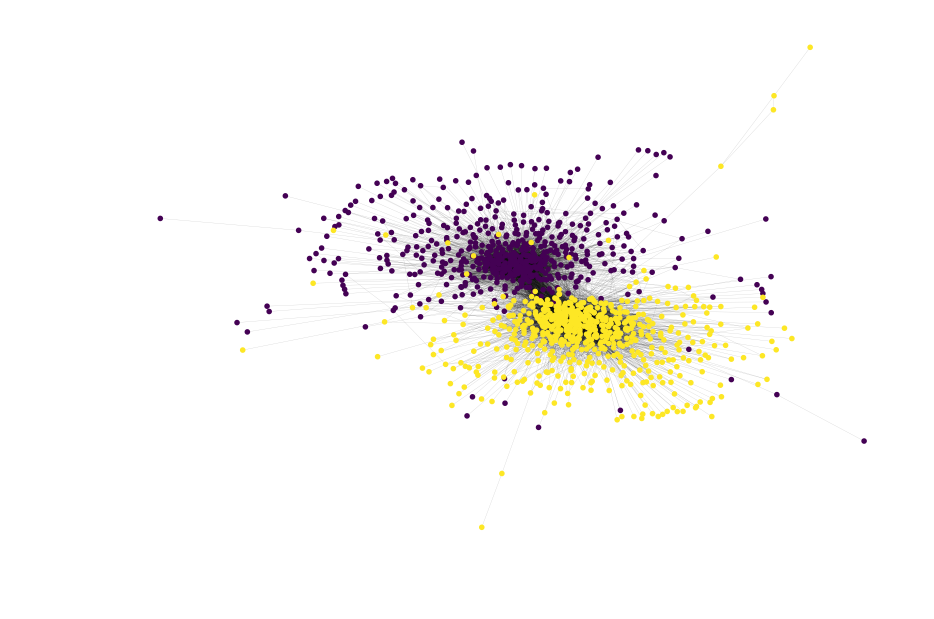

(1222, 16717)

In [4]:
labels = [v for k, v in graph.nodes.data('value')]

plt.figure(figsize=(5, 3.5), dpi=200)
pos = nx.spring_layout(graph)
nx.draw_networkx_edges(graph, pos, width=0.1, alpha=0.2)
nx.draw_networkx_nodes(graph, pos, node_color=labels, node_size=1, cmap='viridis')

plt.axis('off')
plt.show()

len(graph), len(graph.edges)

In [5]:
class NoisyBinaryLabelSampler(object):
    
    def __init__(self, mu, p_err=0):
        
        self.mu = mu
        self.N = len(mu)
        self.p_err = p_err
    
    def __call__(self, i):
        
        p = (1 - self.p_err) if self.mu[i] == 1 else self.p_err
        return 1 if np.random.rand() < p else 0
    
def apply_APT(sampler, T, tau, epsilon):
    
    # initialize with two samples at all arms
    mu_cur = np.array([(sampler(i) + sampler(i)) / 2 for i in range(sampler.N)])
    ns = np.ones(sampler.N) * 2
    
    # apply APT
    mu_hats = np.zeros((T, sampler.N))
    for t in range(T):
        
        i = np.argmin(np.sqrt(ns) * (np.abs(mu_cur - tau) + epsilon))        
        mu_cur[i] = (mu_cur[i] * ns[i] + sampler(i)) / (ns[i] + 1)
        ns[i] += 1
        mu_hats[t, :] = mu_cur.copy()
        
    return mu_hats

def apply_GraphAPL(sampler, T, graph, tau, gamma, epsilon, alpha=1e-8, verbose=True):
    
    gapl = GraphThresholdActiveLearner(graph, tau, gamma, epsilon=epsilon, alpha=alpha)
    
    mu_hats = np.zeros((T, sampler.N))
    
    for t in range(T):
        
        if verbose:
            if (t > 0 and t % 1000 == 0) or t == T - 1:
                print('')
            if t % 10 == 0:
                print('.', end='')
        
        i = gapl.get_next_location()
        gapl.update(i, sampler(i))
        mu_hats[t, :] = gapl.mu_hat.copy()
    
    return mu_hats

def apply_random_sampling_with_laplacian(sampler, T, graph, tau, gamma, epsilon, alpha=1e-8, verbose=True):
    
    gapl = GraphThresholdActiveLearner(graph, tau, gamma, epsilon=epsilon, alpha=alpha)
    
    mu_hats = np.zeros((T, sampler.N))
    perm = np.random.permutation(sampler.N)
    
    for t in range(T):
        
        if verbose:
            if (t > 0 and t % 1000 == 0) or t == T - 1:
                print('')
            if t % 10 == 0:
                print('.', end='')
        
        i = perm[t % T]
        gapl.update(i, sampler(i))
        mu_hats[t, :] = gapl.mu_hat.copy()
    
    return mu_hats

def failure_rate(mu, mu_hats, tau, epsilon):
    check_mask = (np.abs(mu - tau) > epsilon)
    return 1 - np.sum(((mu_hats[:, check_mask] - tau) * (mu[check_mask] - tau)[None, :]) > 0, 1) / mu.size

In [6]:
def run_polblogs(T, gamma, epsilon=0.1, p_err=0, verbose=True):
    
    mu = np.array(labels)
    tau = 0.5
    
    sampler = NoisyBinaryLabelSampler(mu, p_err)
    
    # run GraphAPL
    mu_hats_GraphAPl = apply_GraphAPL(sampler, T, graph, tau, gamma, epsilon, verbose=verbose)
    failure_GraphAPL = failure_rate(mu, mu_hats_GraphAPl, tau, epsilon)
    
    # run APT
    mu_hats_APT = apply_APT(sampler, T, tau, epsilon)
    failure_APT = failure_rate(mu, mu_hats_APT, tau, epsilon)
    
    return failure_GraphAPL, failure_APT

def run_polblogs_rand(T, gamma, epsilon=0.1, p_err=0, verbose=True):
    
    mu = np.array(labels)
    tau = 0.5
    
    sampler = NoisyBinaryLabelSampler(mu, p_err)
    
    # run random with Laplacian
    mu_hats_random = apply_random_sampling_with_laplacian(sampler, T, graph, tau, gamma, epsilon, verbose=verbose)
    failure_random = failure_rate(mu, mu_hats_random, tau, epsilon)
    
    return failure_random

In [7]:
T = len(graph)
gammas = np.logspace(-9, 1, 6)
epsilon = 0.01
p_err = 0

res_AP = GridParallel(n_jobs=7, verbose=1)(run_polblogs, [T], gammas, [epsilon], [p_err], [False])
res_AP_np = np.squeeze(res_AP)

n_trials = 100
res_rand = GridParallel(n_jobs=7, verbose=1)(run_polblogs_rand, [T]*n_trials, gammas, [epsilon], [p_err], [False])
res_rand_np = np.squeeze(res_rand)

Number of tasks: 6.
Number of tasks: 600.


[Parallel(n_jobs=7)]: Done   6 out of   6 | elapsed:   10.1s finished
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   21.8s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  2.3min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  5.5min
[Parallel(n_jobs=7)]: Done 600 out of 600 | elapsed:  7.8min finished


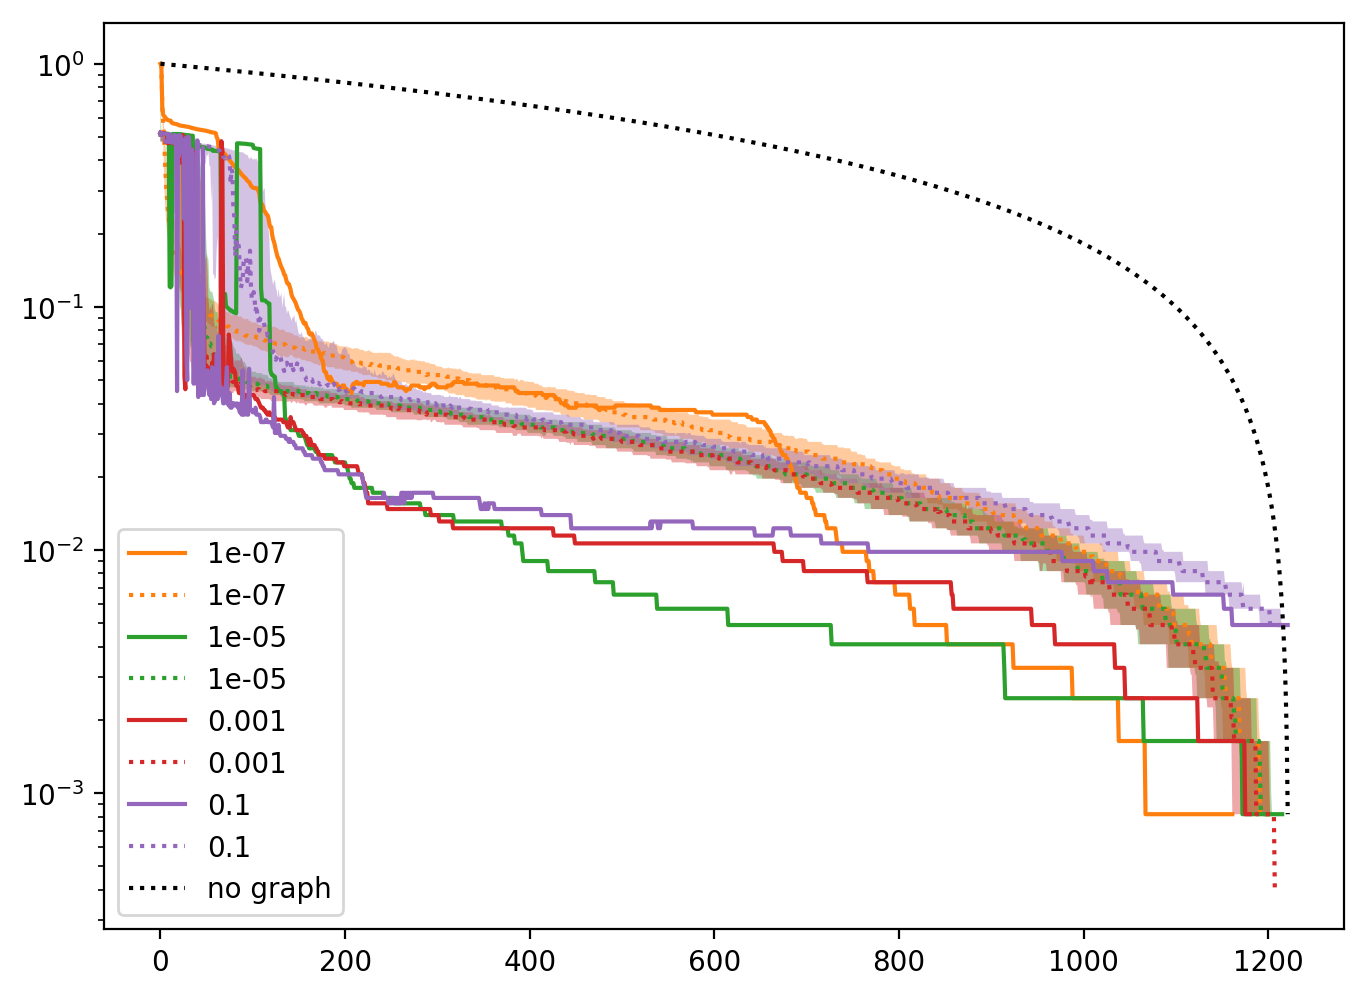

In [8]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 6), dpi=200)
for i, gamma in [(list(gammas).index(gamma), gamma) for gamma in [1e-7, 1e-5, 1e-3, 1e-1]]:
    plt.semilogy(res_AP_np[i, 0, :], c=colors[i], label='%g' % gamma)
    y_1q = np.maximum(1 / len(graph), np.percentile(res_rand_np[:, i, :], 25, 0))
    y_3q = np.maximum(1 / len(graph), np.percentile(res_rand_np[:, i, :], 75, 0))
    plt.fill_between(np.arange(T), y_1q, y_3q, facecolor=colors[i], alpha=0.4)
    plt.semilogy(np.median(res_rand_np[:, i, :], 0), ':', c=colors[i], label='%g' % gamma)
plt.plot(np.arange(T, 0, -1) / T, ':k', label='no graph')
plt.legend()
plt.show()

In [9]:
np.savez('polblogs.npz', res_AP_np=res_AP_np, res_rand_np=res_rand_np)

In [17]:
def compute_d(lamda, eigvals, H, M, mu_norm):
    
    q = 2 * H * (3 * M + 1) ** 2 * mu_norm ** 2 
    v = q / np.log(1 + q / lamda) / eigvals
    
    return np.sum(np.arange(len(v)) <= v)

def compute_optimal_gamma(L, mu, tau, epsilon, alpha, sigma, lamda=1e-3, gamma_0=10):
    
    H = np.sum(1 / (abs(mu - tau) + epsilon)**2)
    mu_norm = np.sqrt((mu - tau) @ ((L + lamda * speye(L.shape[0])) @ (mu - tau)))

    eigvals = np.sort(np.linalg.eigvalsh((L + lamda * speye(L.shape[0])).A))
    gamma = gamma_0

    # iterate a few times to settle any issues with M depending on gamma
    for i in range(100):
        M = max(np.sqrt(1 + alpha), np.sqrt(alpha / gamma / lamda))
        d = compute_d(lamda, eigvals, H, M, mu_norm)
        gamma = sigma / mu_norm * np.sqrt(2 * d * np.log(1 + 2 * H * (3 * M + 1) ** 2 * mu_norm ** 2 / lamda))
    
    return gamma

compute_optimal_gamma(nx.laplacian_matrix(graph), np.array(labels), 0.5, epsilon, 1e-8, 1e-6, gamma_0=1e-5)

6.2085652172682618e-06